In [369]:
import sys

sys.path.append("../src")

In [370]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.linalg import eigh
import sto_ng
import gaussian_overlap_function
import h5py

importlib.reload(sto_ng)
importlib.reload(gaussian_overlap_function)
from sto_ng import *
from gaussian_overlap_function import *

In [371]:
with h5py.File("sto_ng.h5", "r") as f:
    alphas = f["1s/sto-3g/alpha"][:]
    cs = f["1s/sto-3g/c"][:]

In [372]:
# def kinetic_energy(scale, RA, RB):
#    result = 0
#    for i in range(3):
#        for j in range(3):
#            alpha = alphas[i] * scale**2
#            beta = alphas[j] * scale**2
#            c_i = cs[i]
#            c_j = cs[j]
#            Salpha = GaussianOverlapFunction.S(alpha, alpha, RA, RA)
#            Sbeta = GaussianOverlapFunction.S(beta, beta, RB, RB)
#            result += (
#                c_i * c_j * GaussianOverlapFunction.T(alpha, beta, RA, RB)
#            ) / np.sqrt(Salpha * Sbeta)
#    return result

In [373]:
def kinetic_energy(scale, RA, RB):
    scaled_alpha = (alphas * scale**2)[:, None]
    scaled_beta = (alphas * scale**2)[None, :]
    c_i = cs[:, None]
    c_j = cs[None, :]
    Salpha = GaussianOverlapFunction.S(scaled_alpha, scaled_alpha, RA, RA)
    Sbeta = GaussianOverlapFunction.S(scaled_beta, scaled_beta, RB, RB)
    return np.sum(
        c_i
        * c_j
        * GaussianOverlapFunction.T(scaled_alpha, scaled_beta, RA, RB)
        / np.sqrt(Salpha * Sbeta)
    )

In [374]:
def kinetic_energy_matrix(scale, Rs):
    mat = np.zeros((2, 2))
    for p in range(2):
        for q in range(2):
            mat[p, q] = kinetic_energy(scale, Rs[p], Rs[q])
    return mat

In [375]:
def coulomb_from_ion(scale, RA, RB, RC):
    result = 0
    for i in range(3):
        for j in range(3):
            alpha = alphas[i] * scale**2
            beta = alphas[j] * scale**2
            c_i = cs[i]
            c_j = cs[j]
            Salpha = GaussianOverlapFunction.S(alpha, alpha, RA, RA)
            Sbeta = GaussianOverlapFunction.S(beta, beta, RB, RB)
            result += (
                c_i * c_j * (GaussianOverlapFunction.V(alpha, beta, RA, RB, RC))
            ) / np.sqrt(Salpha * Sbeta)
    return result

In [394]:
RA = np.array([0.0, 0.0, 0.0])
RB = np.array([1.0, 0.0, 0.0])
RC = np.array([0.0, 1.0, 0.0])

coulomb_from_ion(1.0, RA, RB, RC)

-0.578577848944339

In [395]:
print(GaussianOverlapFunction.V(0.1, 0.1, RA, RB, RC))
print(GaussianOverlapFunction.V(1.0, 1.0, RA, RB, RC))

-27.569615980832197
-1.0409442006636709


In [408]:
def RP(alpha, beta, RA, RB):
    return (alpha * RA + beta * RB) / (alpha + beta)


print(RP(1.0, 1.0, RA, RB))
print(RP(0.1, 1.0, RA, RB))
print(RP(1.0, 0.1, RA, RB))
print(RP(0.1, 0.1, RA, RB))

[0.5 0.  0. ]
[0.90909091 0.         0.        ]
[0.09090909 0.         0.        ]
[0.5 0.  0. ]


In [407]:
scaled_alpha = np.array([0.1, 1.0])
RP(
    scaled_alpha[:, None, None],
    scaled_alpha[None, :, None],
    RA[None, None, :],
    RB[None, None, :],
)

array([[[0.5       , 0.        , 0.        ],
        [0.90909091, 0.        , 0.        ]],

       [[0.09090909, 0.        , 0.        ],
        [0.5       , 0.        , 0.        ]]])

In [409]:
scaled_alphas = np.array([0.1, 1.0])[:, None, None]
scaled_betas = np.array([0.1, 1.0])[None, :, None]
print(scaled_alphas)
print(scaled_betas)
print(
    GaussianOverlapFunction.V(
        scaled_alphas,
        scaled_betas,
        RA[None, None, :],
        RB[None, None, :],
        RC[None, None, :],
    )
)

[[[0.1]]

 [[1. ]]]
[[[0.1]
  [1. ]]]
[[[-21.94548766]
  [ -1.90692127]]

 [[ -1.90692127]
  [ -0.51698205]]]


In [456]:
def V2(alpha, beta, RA, RB, RC):
    RP = (
        alpha[:, None, None] * RA[None, None, :]
        + beta[None, :, None] * RB[None, None, :]
    ) / (alpha[:, None, None] + beta[None, :, None])
    RP_RC_norm_sq = np.linalg.norm(RP - RC, axis=2) ** 2
    gamma = alpha[:, None] + beta[None, :]
    return (
        -2
        * np.pi
        / gamma
        * np.exp(-alpha[:, None] * beta[None, :] * np.linalg.norm(RA - RB) ** 2 / gamma)
        * GaussianOverlapFunction.F(gamma * RP_RC_norm_sq)
    )

In [457]:
scaled_alphas = np.array([0.1, 1.0])
scaled_betas = np.array([0.1, 1.0])
V2(scaled_alphas, scaled_betas, RA, RB, RC)

array([[-27.56961598,  -3.11421671],
       [ -3.79038291,  -1.0409442 ]])

In [444]:
print(V2(0.1, 0.1, RA[None, None, :], RB[None, None, :], RC[None, None, :]))
print(V2(1.0, 0.1, RA[None, None, :], RB[None, None, :], RC[None, None, :]))
print(V2(0.1, 1.0, RA[None, None, :], RB[None, None, :], RC[None, None, :]))
print(V2(1.0, 1.0, RA[None, None, :], RB[None, None, :], RC[None, None, :]))

[[-27.56961598]]
[[-3.79038291]]
[[-3.11421671]]
[[-1.0409442]]


In [415]:
GaussianOverlapFunction.F(0.1)

0.9676433126041887

In [414]:
np.linalg.norm(RB[None, :])

1.0

In [411]:
GaussianOverlapFunction.V(0.1, 0.1, RA, RB, RC)

-27.569615980832197

In [402]:
np.linalg.norm(RA[None, None, :] - RB[None, None, :])

1.0

In [397]:
(0.1 * RA + 0.1 * RB) / 0.2

array([0.5, 0. , 0. ])

In [398]:
RB

array([1., 0., 0.])

In [399]:
RP = (scaled_alphas * RA[None, None, :] + scaled_betas * RB[None, None, :]) / (
    scaled_alphas + scaled_betas
)
RP

array([[[0.5       , 0.        , 0.        ],
        [0.90909091, 0.        , 0.        ]],

       [[0.09090909, 0.        , 0.        ],
        [0.5       , 0.        , 0.        ]]])

In [400]:
scale = 1.0

scaled_alpha = (alphas * scale**2)[:, None, None]
scaled_beta = (alphas * scale**2)[None, :, None]
c_i = cs[:, None, None]
c_j = cs[None, :, None]
Salpha = GaussianOverlapFunction.S(
    scaled_alpha, scaled_alpha, RA[None, None, :], RA[None, None, :]
)
Sbeta = GaussianOverlapFunction.S(
    scaled_beta, scaled_beta, RB[None, None, :], RB[None, None, :]
)

np.sum(
    c_i
    * c_j
    * (
        GaussianOverlapFunction.V(
            scaled_alpha,
            scaled_beta,
            RA[None, None, :],
            RB[None, None, None, :],
            RC[None, None, None, None, :],
        )
    )
    / np.sqrt(Salpha * Sbeta)
)

-0.2459459777660369

In [380]:
def coulomb_from_ion_matrix(scale, Rs, ion_num):
    mat = np.zeros((2, 2))
    for p in range(2):
        for q in range(2):
            mat[p, q] = coulomb_from_ion(scale, Rs[p], Rs[q], Rs[ion_num])
    return mat


def ee_coulomb(scale, RA, RB, RC, RD):
    result = 0
    scaled_alphas = alphas * scale**2
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    alpha = scaled_alphas[i]
                    beta = scaled_alphas[j]
                    gamma = scaled_alphas[k]
                    delta = scaled_alphas[l]
                    c_i = cs[i]
                    c_j = cs[j]
                    c_k = cs[k]
                    c_l = cs[l]
                    Salpha = GaussianOverlapFunction.S(alpha, alpha, RA, RA)
                    Sbeta = GaussianOverlapFunction.S(beta, beta, RB, RB)
                    Sgamma = GaussianOverlapFunction.S(gamma, gamma, RC, RC)
                    Sdelta = GaussianOverlapFunction.S(delta, delta, RD, RD)
                    result += (
                        c_i
                        * c_j
                        * c_k
                        * c_l
                        * (
                            GaussianOverlapFunction.U(
                                alpha, beta, gamma, delta, RA, RB, RA, RB
                            )
                        )
                    ) / np.sqrt(Salpha * Sbeta * Sgamma * Sdelta)
    return result


Rs = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]]) * 0
ee_coulomb(1.0, Rs[0], Rs[1], Rs[2], Rs[3])

0.6246844278389933

In [381]:
def ee_coulomb(scale, RA, RB, RC, RD):
    result = 0
    scaled_alphas = alphas * scale**2
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    alpha = scaled_alphas[i]
                    beta = scaled_alphas[j]
                    gamma = scaled_alphas[k]
                    delta = scaled_alphas[l]
                    c_i = cs[i]
                    c_j = cs[j]
                    c_k = cs[k]
                    c_l = cs[l]
                    Salpha = GaussianOverlapFunction.S(alpha, alpha, RA, RA)
                    Sbeta = GaussianOverlapFunction.S(beta, beta, RB, RB)
                    Sgamma = GaussianOverlapFunction.S(gamma, gamma, RC, RC)
                    Sdelta = GaussianOverlapFunction.S(delta, delta, RD, RD)
                    result += (
                        c_i
                        * c_j
                        * c_k
                        * c_l
                        * (
                            GaussianOverlapFunction.U(
                                alpha, beta, gamma, delta, RA, RB, RA, RB
                            )
                        )
                    ) / np.sqrt(Salpha * Sbeta * Sgamma * Sdelta)
    return result

In [382]:
RA = Rs[0]
RB = Rs[1]
RC = Rs[2]
RD = Rs[3]

scaled_alpha = (alphas * 1.0**2)[:, None, None, None]
scaled_beta = (alphas * 1.0**2)[None, :, None, None]
scaled_gamma = (alphas * 1.0**2)[None, None, :, None]
scaled_delta = (alphas * 1.0**2)[None, None, None, :]
c_alpha = cs[:, None, None, None]
c_beta = cs[None, :, None, None]
c_gamma = cs[None, None, :, None]
c_delta = cs[None, None, None, :]

Salpha = GaussianOverlapFunction.S(scaled_alpha, scaled_alpha, RA, RA)
Sbeta = GaussianOverlapFunction.S(scaled_beta, scaled_beta, RB, RB)
Sgamma = GaussianOverlapFunction.S(scaled_gamma, scaled_gamma, RC, RC)
Sdelta = GaussianOverlapFunction.S(scaled_delta, scaled_delta, RD, RD)

np.sum(
    c_alpha
    * c_beta
    * c_gamma
    * c_delta
    * GaussianOverlapFunction.U(
        scaled_alpha, scaled_beta, scaled_gamma, scaled_delta, RA, RB, RC, RD
    )
    / np.sqrt(Salpha * Sbeta * Sgamma * Sdelta)
)

0.6246844278389933

In [383]:
Rs = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])
ee_coulomb(1.0, Rs[0], Rs[1], Rs[2], Rs[3])

0.5543872112446866

In [384]:
def ee_coulomb_matrix(scale, Rs, Cr, Cs):
    mat = np.zeros((2, 2))
    for p in range(2):
        for q in range(2):
            result = 0
            for r in range(2):
                for s in range(2):
                    result += Cr * Cs * ee_coulomb(scale, Rs[p], Rs[q], Rs[r], Rs[s])
            mat[p, q] = result
    return mat


def S_mel(scale, RA, RB):
    result = 0
    for i in range(3):
        for j in range(3):
            alpha = alphas[i] * scale**2
            beta = alphas[j] * scale**2
            c_i = cs[i]
            c_j = cs[j]
            result += c_i * c_j * GaussianOverlapFunction.S(alpha, beta, RA, RB)
    return result


def S_matrix(scale, Rs):
    mat = np.zeros((2, 2))
    for p in range(2):
        for q in range(2):
            mat[p, q] = S_mel(scale, Rs[p], Rs[q])
    return mat

In [385]:
alphas[:, None]

array([[2.22884146],
       [0.10986104],
       [0.40597907]])

In [386]:
Rs = np.array([[0, 0, 0], [1.0, 0, 0]])
ee_coulomb(1.0, Rs[0], Rs[0], Rs[0], Rs[0])

0.6246844278389933

In [387]:
zeta = 1.0


def total_energy(zeta, Rs):
    Cr, Cs = 1.0 / np.sqrt(2), 1.0 / np.sqrt(2)
    vec = np.array([Cr, Cs])
    hamilltonian_1e = (
        kinetic_energy_matrix(zeta, Rs)
        + coulomb_from_ion_matrix(zeta, Rs, 0)
        + coulomb_from_ion_matrix(zeta, Rs, 1)
    )
    hamilltonian_2e = ee_coulomb_matrix(zeta, Rs, Cr, Cs)

    energy_1e = np.dot(vec, np.dot(hamilltonian_1e, vec))
    energy_2e = np.dot(vec, np.dot(hamilltonian_2e, vec))
    energy_ion_ion = 1 / np.linalg.norm(Rs[0] - Rs[1])

    energy = 2 * energy_1e + energy_2e + energy_ion_ion

    return energy


rs = np.linspace(0.5, 5.0, 100)
energies = []
for r in np.linspace(0.5, 5.0, 100):
    print(r)
    Rs = np.array([[0, 0, 0], [r, 0, 0]])
    energies.append(minimize(lambda zeta: total_energy(zeta, Rs), zeta).fun)

0.5


/tmp/ipykernel_286174/4051239141.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[p, q] = coulomb_from_ion(scale, Rs[p], Rs[q], Rs[ion_num])


0.5454545454545454
0.5909090909090909
0.6363636363636364
0.6818181818181819
0.7272727272727273
0.7727272727272727
0.8181818181818181
0.8636363636363636
0.9090909090909092
0.9545454545454546
1.0
1.0454545454545454
1.0909090909090908
1.1363636363636362
1.1818181818181819
1.2272727272727273
1.2727272727272727
1.3181818181818183
1.3636363636363638
1.4090909090909092
1.4545454545454546
1.5
1.5454545454545454
1.5909090909090908
1.6363636363636365
1.6818181818181819
1.7272727272727273
1.7727272727272727
1.8181818181818181
1.8636363636363638


1.9090909090909092
1.9545454545454546
2.0
2.0454545454545454
2.090909090909091
2.1363636363636367
2.1818181818181817
2.2272727272727275
2.2727272727272725
2.3181818181818183
2.3636363636363638
2.409090909090909
2.4545454545454546
2.5
2.5454545454545454
2.590909090909091
2.6363636363636362
2.6818181818181817
2.7272727272727275
2.772727272727273
2.8181818181818183
2.8636363636363638
2.909090909090909
2.9545454545454546
3.0
3.0454545454545454
3.090909090909091
3.1363636363636362
3.181818181818182


KeyboardInterrupt: 

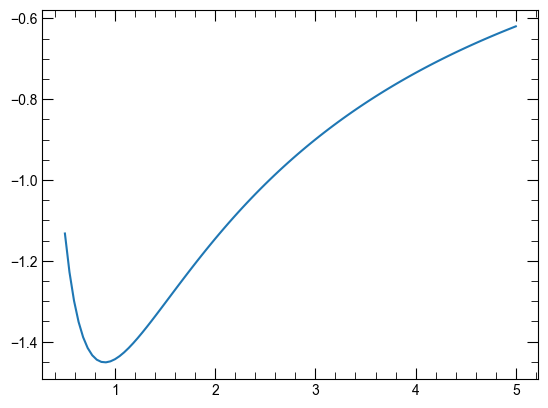

In [ ]:
fig, ax = plt.subplots()
ax.plot(rs, energies)

In [ ]:
Rs = [np.array([0, 0, 0]), np.array([0, 0, 0])]
k = kinetic_energy(zeta, Rs[0], Rs[1])

In [ ]:
v = coulomb_from_ion(zeta, Rs[0], Rs[1], Rs[0])

In [ ]:
2 * k + 4 * v

-2.968253656869835

In [ ]:
zetas = np.linspace(0.5, 2, 100)
energies = [total_energy(zeta) for zeta in zetas]
fig, ax = plt.subplots()
ax.plot(zetas, energies)

TypeError: total_energy() missing 1 required positional argument: 'Rs'

In [ ]:
result = minimize(total_energy, 1.0)
result

/tmp/ipykernel_286174/2909821671.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[p, q] = kinetic_energy(scale, Rs[p], Rs[q])
/tmp/ipykernel_286174/2909821671.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[p, q] = coulomb_from_ion(scale, Rs[p], Rs[q], Rs[ion_num])
/tmp/ipykernel_286174/2909821671.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[p, q] = result


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.337182550138181
        x: [ 7.482e-01]
      nit: 6
      jac: [ 0.000e+00]
 hess_inv: [[ 1.717e-01]]
     nfev: 16
     njev: 8

In [ ]:
result.x

array([0.74818842])

In [ ]:
optimized_params_1s

array([2.22884146, 0.15423817, 0.10986104, 0.44487558, 0.40597907,
       0.53517486])

In [ ]:
results = []
scales = np.linspace(0.0, 1.5, 100)
for scale in scales:
    results.append(total_energy(scale))

/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.pi / (alpha + beta)) ** (3 / 2) * np.exp(
/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:57: RuntimeWarning: invalid value encountered in scalar divide
  -alpha * beta / (alpha + beta) * np.linalg.norm(RA - RB) ** 2
/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:14: RuntimeWarning: invalid value encountered in scalar divide
  alpha
/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:17: RuntimeWarning: invalid value encountered in scalar divide
  * (6 - 4 * alpha * beta / (alpha + beta) * np.linalg.norm(RA - RB) ** 2)
/home/yamamoto/physics/molecule/examples/../src/gaussian_overlap_function.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  * (np.pi / (alpha + beta)) ** (3 / 2)
/home/yamamoto/physics/molecule/examples/../src/gaussian

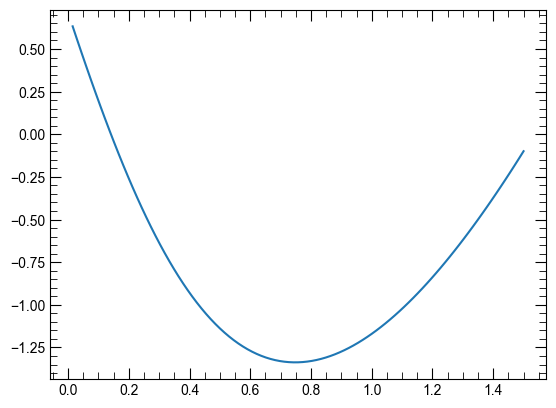

In [ ]:
fig, ax = plt.subplots()
ax.plot(scales, results)

In [ ]:
optimized_params_1s[0] * optimized_params_1s[1]

0.34377242342723485

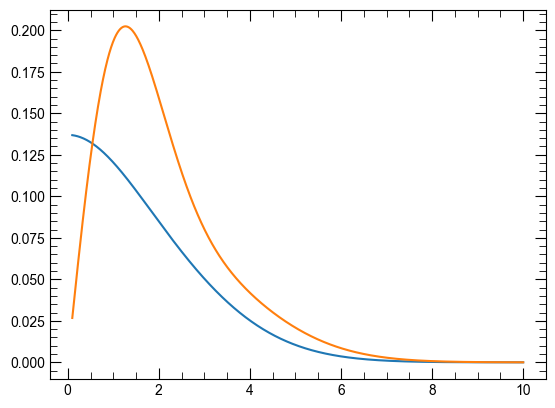

In [ ]:
approximator = GaussianApproximator2s2p(optimized_params_2s2p, 1.0)
r = np.linspace(0.1, 10, 1000)
y2s = approximator.phi_approx_g1s(optimized_params_2s2p, r)
y2p = approximator.phi_approx_g2p(optimized_params_2s2p, r)
fig, ax = plt.subplots()
ax.plot(r, y2s)
ax.plot(r, y2p)